# 3) Evaluation Code

## Imports

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle
import librosa as lb

## Evaluate hypothesis directory

In [3]:
def get_timestamps(annotfile, subseq=False, offset=None, length=None):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    timestamps = np.array(df[0])
    if subseq:
        return timestamps, int(df[2][0].split("-")[-1]), len(timestamps)
    if offset:
        return timestamps[offset:offset+length], None, None
    return timestamps, None, None

def eval_file(hypfile, hop_sec, annotation_root1, annotation_root2):

    piece1, piece2 = os.path.basename(hypfile).split('__') # ['Chopin_Op017No4_Fou-1978_pid9071-20', 'Chopin_Op017No4_Magaloff-1977_pid5667267b-10.pkl']
    mazurka = '_'.join(os.path.basename(piece1).split('_')[0:2]) # Chopin_Op017No4
    annotation1 = (Path(annotation_root1) / mazurka / piece1).with_suffix('.beat') # Mazurkas_median_x1.260_subseq20/annotations_beat/Chopin_Op017No4/Chopin_Op017No4_Fou-1978_pid9071-20.beat
    annotation2 = (Path(annotation_root2) / mazurka / piece2).with_suffix('.beat') # Mazurkas_median_x0.794/annotations_beat/Chopin_Op017No4/Chopin_Op017No4_Magaloff-1977_pid5667267b-10.beat

    # check if first annotation file is a subsequence file
    subseq = True if "subseq20" in str(annotation1) else False
    t1, offset, length = get_timestamps(annotation1, subseq, None, None)
    t2, _, _ = get_timestamps(annotation2, False, offset, length)

    hypalign = pd.read_pickle(hypfile) # warping path in frames
    return [] if hypalign is None else np.interp(t1, hypalign[0,:]*hop_sec, hypalign[1,:]*hop_sec) - t2

def eval_dir(hypdir, querylist, hop_sec, annotation_root1, annotation_root2, savefile = None):
    all_errs, count = {}, 0
    print(f'Processing {querylist} and {hypdir} ', end='')
    with open(querylist, 'r') as f:
        for line in f:
            piece1, piece2 = line.strip().split()
            basename = os.path.basename(piece1) + '__' + os.path.basename(piece2)
            hypfile = hypdir + '/' + basename + '.pkl'
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
            all_errs[basename] = eval_file(hypfile, hop_sec, annotation_root1, annotation_root2)
            count += 1
            if count % 500 == 0:
                print(".", end='')
    print(' done')
    if savefile:
        pickle.dump(all_errs, open(savefile, 'wb'))

def eval_all_dirs(rootdir, querylist, hop_sec, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    dataset = str(querylist).split('/')[1].replace(".txt", "") # train_toy

    for hypdir in os.listdir(rootdir):
        savefile = outdir + '/' + dataset + '.' + os.path.basename(hypdir) + '.pkl' # savefile = outdir + '/' + os.path.basename(hypdir) + '.pkl'
        info = hypdir.split('_')
        subseq, piece1, piece2 = info[-3], info[-2], info[-1]
        subseq = "_subseq20" if "Sub" in subseq else ""
        annotation_root1 = f'Mazurkas_median_{piece1}{subseq}/annotations_beat'
   
        annotation_root2 = f'Mazurkas_median_{piece2}/annotations_beat'
        eval_dir(rootdir + '/' + hypdir, querylist, hop_sec, annotation_root1, annotation_root2, savefile)

## Define constants

In [4]:
ANNOTATIONS_ROOT = Path('Chopin_Mazurkas/annotations_beat')
query_list_train_toy = Path('cfg_files/train_toy.txt')
query_list_train_small = Path('cfg_files/train_small.txt')
query_list_train_medium = Path('cfg_files/train_medium.txt')
query_list_train_full = Path('cfg_files/train_full.txt')
query_list_test_full = Path('cfg_files/test_full.txt')

EXPERIMENTS_ROOT = 'experiments'
HOP_SEC = 512 * 1 / 22050
EVAL_ROOT_DIR = 'evaluations'

### Evaluate all directories with train_toy

In [5]:
eval_all_dirs(EXPERIMENTS_ROOT, query_list_train_toy, HOP_SEC, EVAL_ROOT_DIR)

Processing cfg_files/train_toy.txt and experiments/DTW1_add4_x2.000_x0.500  done
Processing cfg_files/train_toy.txt and experiments/DTW2_x2.000_x0.500  done
Processing cfg_files/train_toy.txt and experiments/adaptiveWeight2_x1.588_x0.630  done
Processing cfg_files/train_toy.txt and experiments/DTW2_x1.588_x0.794  done
Processing cfg_files/train_toy.txt and experiments/downsampleQuantized_x2.000_x0.630  done
Processing cfg_files/train_toy.txt and experiments/DTW3_x2.000_x0.500  done
Processing cfg_files/train_toy.txt and experiments/DTW1_add3_x2.000_x0.630  done
Processing cfg_files/train_toy.txt and experiments/adaptiveWeight1_x1.260_x0.794  done
Processing cfg_files/train_toy.txt and experiments/DTW5_x1.260_x1.000  done
Processing cfg_files/train_toy.txt and experiments/DTW1_add3_x1.000_x1.000  done
Processing cfg_files/train_toy.txt and experiments/adaptiveWeight1_x1.000_x1.000  done
Processing cfg_files/train_toy.txt and experiments/DTW3_x2.000_x0.630  done
Processing cfg_files/trai

# Plot error vs tolerance

##### Helper functions for plotting graphs

In [32]:
def get_global_time_warp(num1, num2):
    ''' calculate global time warp from two numbers'''
    return round(num1/num2, 3)

In [113]:
def get_info_from_basename(dir): # dir would be 'train_toy.DTW1_add3_x1.000_x1.000'
    '''get system, global_time_warp from basename (name of a folder)'''
    
    # old used to be 'train_toy.x2000.x0630.SubDTW_selectiveTransitions2.pkl'
    info = dir.split('_')
    print(info)
    if len(info) == 5: # is a DTW_addX
        system = "{}_{}".format(info[1][4:], info[2])
    else:
        system = info[1].split(".")[-1]
    
    num1 = float('{}'.format(info[-2][1:])).
    num2 = float('{}'.format(info[-1][1:]))
    global_time_warp = get_global_time_warp(num1, num2)
    return system, global_time_warp

In [46]:
def get_folder_names(filelist, alignments_list):
    '''create a list of lists of folder names corresponding to filelist and alignment types'''
    all_folders = []
    for alignment in alignments_list:
        to_concat = ['{}.{}_x1.000_x1.000'.format(filelist, alignment), '{}.{}_x1.260_x0.794'.format(filelist, alignment), '{}.{}_x1.260_x1.000'.format(filelist, alignment),
                     '{}.{}_x1.588_x0.630'.format(filelist, alignment), '{}.{}_x1.588_x0.794'.format(filelist, alignment),
                     '{}.{}_x2.000_x0.630'.format(filelist, alignment), '{}.{}_x2.000_x0.500'.format(filelist, alignment)]
        
        all_folders = all_folders + to_concat
    return all_folders

##### Calculate errors

In [47]:
def calc_error_rates(errFile, maxTol):
    # read from file
    with open(errFile, 'rb') as f:
        allErrs = pickle.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        errs = np.array(allErrs[query])
        errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [48]:
def calc_error_rates_batch(indir, basenames, maxTol):
    errRates = np.zeros((len(basenames), maxTol+1))
    allErrVals = []
    print('Computing error rates ', end='')
    for i, basename in enumerate(basenames):
        errFile = indir + '/' + basename + '.pkl'
        errRates[i,:], errors = calc_error_rates(errFile, maxTol)
        allErrVals.append(errors)
        print('.', end='')
    print(' done')
    return errRates, allErrVals

In [49]:
def plot_multiple_roc(errRates, basenames):
    numSystems = errRates.shape[0]
    maxTol = errRates.shape[1] - 1
    for i in range(numSystems):
        plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
        
    # create appropriate legend names corresponding to basenames
    legend = []
    for folder in basenames:
        system, global_time_warp = get_info_from_basename(folder)
        legend.append('Global Time Warp = {}, {}'.format(global_time_warp, system))
    
    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.show()
    return

Note: change the 'toPlot' list to include only the alignment algorithms we've run so far.

In [50]:
toPlot = get_folder_names('train_toy', ['DTW1', 'DTW2', 'DTW3', 'DTW4', 'DTW5', 'DTW1_add3', 'DTW1_add4', 'downsampleQuantized', 'downsampleInterpolate', 'adaptiveWeight1', 'adaptiveWeight2', 'selectiveTransitions2','selectiveTransitions3','selectiveTransitions4', 'selectiveTransitions5'])
maxTol = 1000 # in msec
errRates, errVals = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)

Computing error rates ......................................................................................................... done


In [106]:
toPlot

['train_toy.DTW1_x1.000_x1.000',
 'train_toy.DTW1_x1.260_x0.794',
 'train_toy.DTW1_x1.260_x1.000',
 'train_toy.DTW1_x1.588_x0.630',
 'train_toy.DTW1_x1.588_x0.794',
 'train_toy.DTW1_x2.000_x0.630',
 'train_toy.DTW1_x2.000_x0.500',
 'train_toy.DTW2_x1.000_x1.000',
 'train_toy.DTW2_x1.260_x0.794',
 'train_toy.DTW2_x1.260_x1.000',
 'train_toy.DTW2_x1.588_x0.630',
 'train_toy.DTW2_x1.588_x0.794',
 'train_toy.DTW2_x2.000_x0.630',
 'train_toy.DTW2_x2.000_x0.500',
 'train_toy.DTW3_x1.000_x1.000',
 'train_toy.DTW3_x1.260_x0.794',
 'train_toy.DTW3_x1.260_x1.000',
 'train_toy.DTW3_x1.588_x0.630',
 'train_toy.DTW3_x1.588_x0.794',
 'train_toy.DTW3_x2.000_x0.630',
 'train_toy.DTW3_x2.000_x0.500',
 'train_toy.DTW4_x1.000_x1.000',
 'train_toy.DTW4_x1.260_x0.794',
 'train_toy.DTW4_x1.260_x1.000',
 'train_toy.DTW4_x1.588_x0.630',
 'train_toy.DTW4_x1.588_x0.794',
 'train_toy.DTW4_x2.000_x0.630',
 'train_toy.DTW4_x2.000_x0.500',
 'train_toy.DTW5_x1.000_x1.000',
 'train_toy.DTW5_x1.260_x0.794',
 'train_to

In [109]:
get_info_from_basename('train_toy.DTW1_add3_x1.000_x1.000')

('DTW1', 1.0)

In [51]:
# plot_multiple_roc(errRates, toPlot)

# Graph Grouped Barplots

#### Graphing all systems

In [52]:
def generate_df(errRates, basenames, tols):
    '''generates df to use with histogram'''
    data = []
    for i, dir in enumerate(basenames):
        # get system from basename
        system, global_time_warp = get_info_from_basename(dir)
        # for tol in tols:
        for tol in tols:
            # get errors and append
            data.append((system, tol, errRates[i,tol]*100, global_time_warp))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error', 'Global Time Warp'])

    # check for NaN which indicates a false path and set error to 100
    #df.fillna(100, inplace=True)

    return df

In [53]:
def generate_df_with_tols(errRates, basenames, tols):
    '''generates df to use with histogram'''
    data = []
    for i, dir in enumerate(basenames):
        # get system from basename
        system, global_time_warp = get_info_from_basename(dir)
        # get errors and append
        data.append((system, errRates[i,100]*100, errRates[i,200]*100, errRates[i,500]*100, global_time_warp))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance 100 Error', 'Tolerance 200 Error','Tolerance 500 Error', 'Global Time Warp'])

    # check for NaN which indicates a false path and set error to 100
    #df.fillna(100, inplace=True)

    return df

In [54]:
def plot_grouped_barplot(df):  
    plt.figure(figsize=(10,10))

    tol_200 = df[df['Tolerance']==200]
    graph200 = sns.barplot(data=tol_200, x="Global Time Warp", y="Error", hue="System", palette="Paired")
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Global Time Warp", size=16)
    plt.ylabel("Error Rate", size=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
    plt.grid()
    plt.show()
    
    return

In [55]:
def plot_with_tols(df):
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.barplot(data=df, x="Global Time Warp", y="Tolerance 200 Error", hue="System", palette="Paired", ax=ax)

    for ix, a in enumerate(ax.patches):
        x_start = a.get_x()
        width = a.get_width()
        ax.plot([x_start, x_start+width], 2*[df.loc[ix, 'Tolerance 500 Error']], '-', c='k')
        ax.plot([x_start, x_start+width], 2*[df.loc[ix, 'Tolerance 100 Error']], '-', c='k')

    plt.xlabel("Global Time Warp", size=16)
    plt.ylabel("Error Rate", size=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)
    plt.grid()
    plt.show()

    return

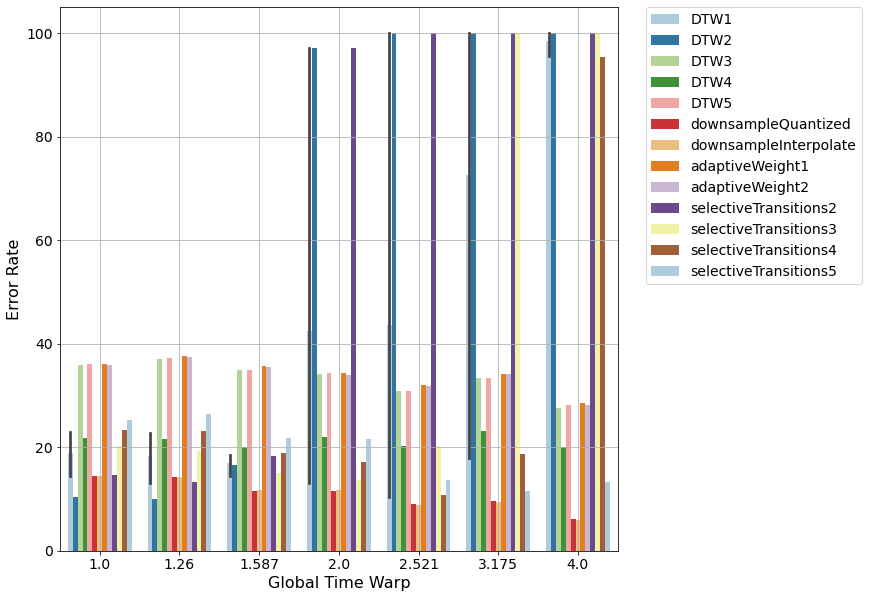

In [56]:
df1 = generate_df(errRates, toPlot, [200, 500, 100])
plot_grouped_barplot(df1)

### Graph Error Tolerances 100 and 500

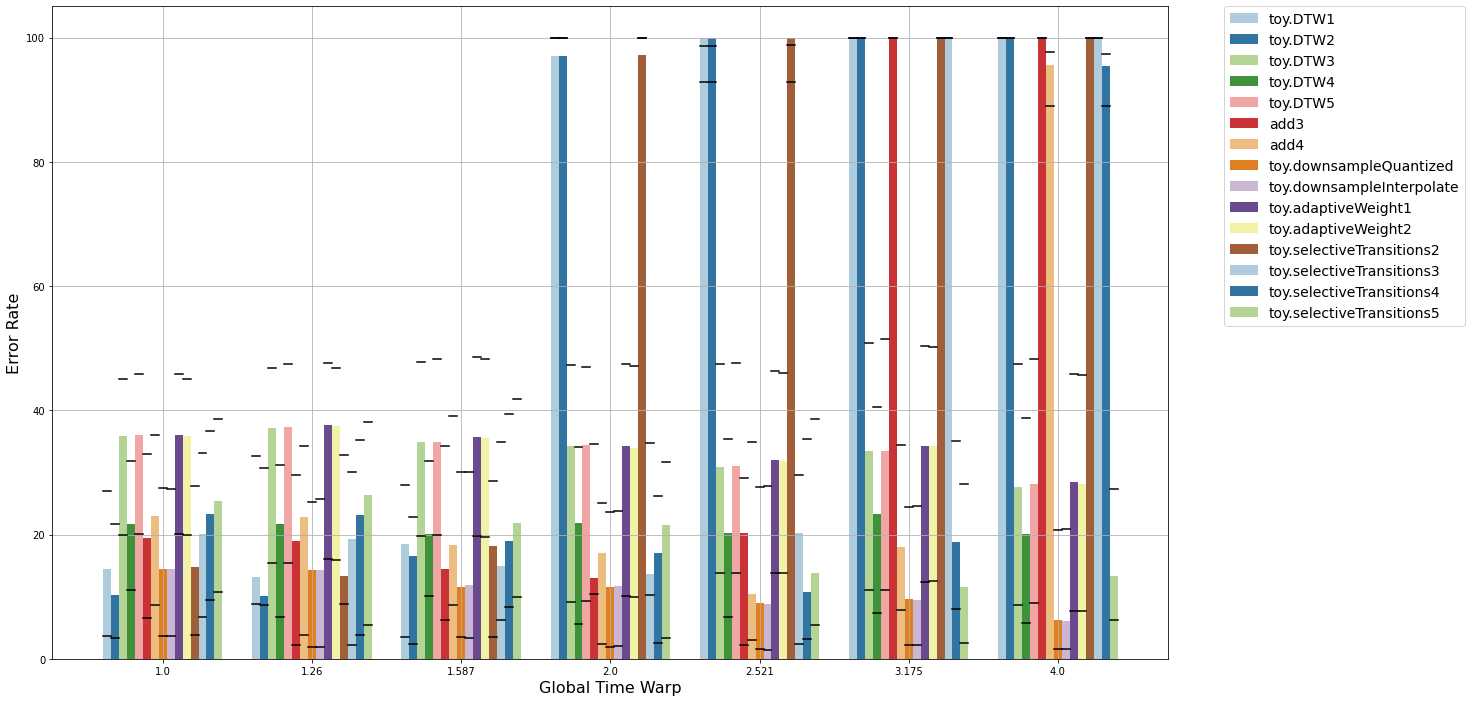

In [91]:
df1_tols = generate_df_with_tols(errRates, toPlot, [200, 500, 100])
plot_with_tols(df1_tols)

#### Graph for DTW1, DTW2, DTW3

Computing error rates ..................... done


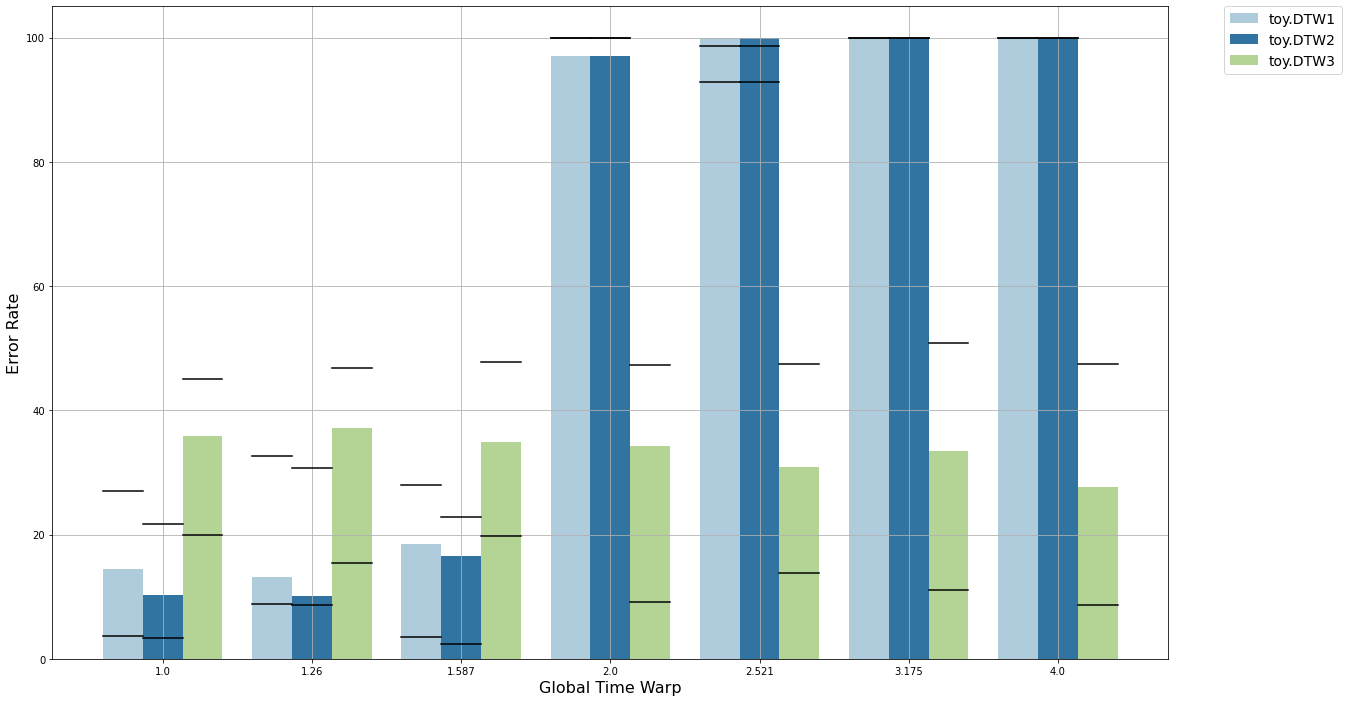

In [92]:
toPlot_normal = get_folder_names('train_toy',['DTW1', 'DTW2', 'DTW3'])
maxTol = 1000 # in msec
errRates_normal, errVals_normal = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot_normal, maxTol)
df_normal = generate_df_with_tols(errRates_normal, toPlot_normal, [200, 500, 100])
plot_with_tols(df_normal)

#### Graph for DTW1_add3, DTW1_add4

Computing error rates .............. done


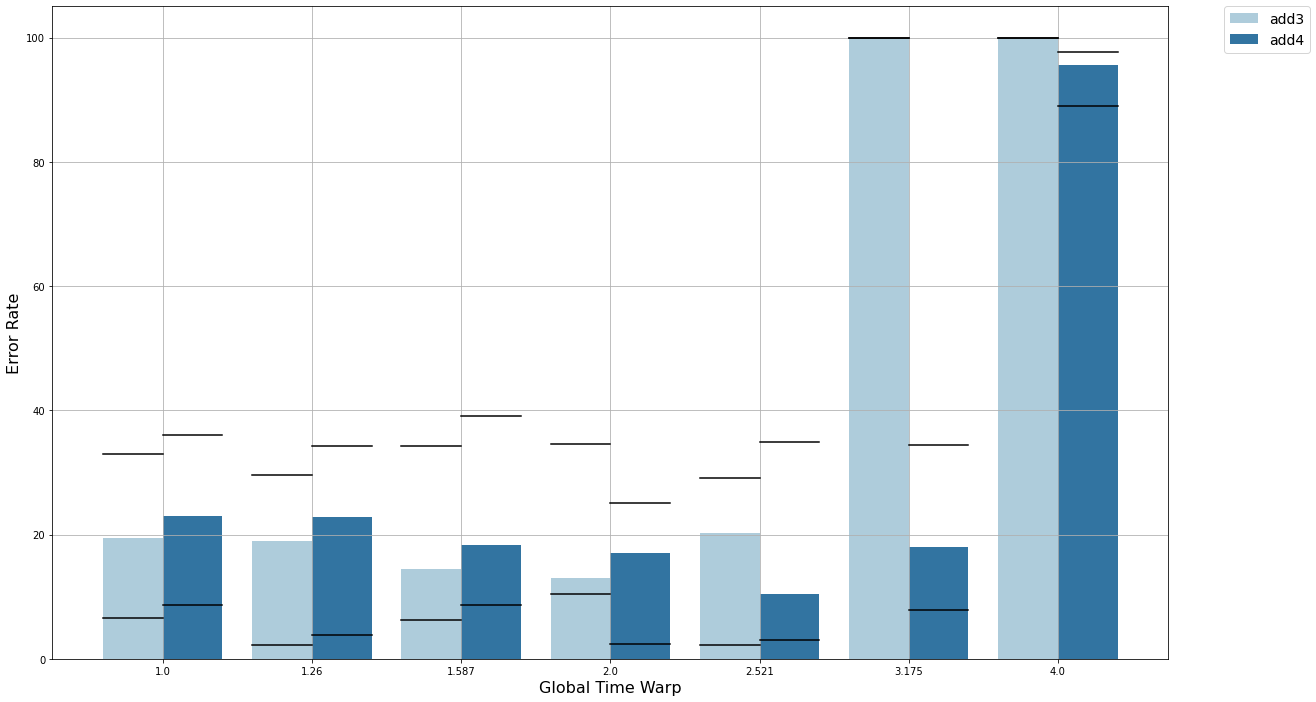

In [93]:
toPlot_add = get_folder_names('train_toy',['DTW1_add3', 'DTW1_add4'])
maxTol = 1000 # in msec
errRates_add, errVals_add = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot_add, maxTol)
df_add = generate_df_with_tols(errRates_add, toPlot_add, [200, 500, 100])
plot_with_tols(df_add)

#### Graph for downsample and upsample DTWs

Computing error rates ..................... done


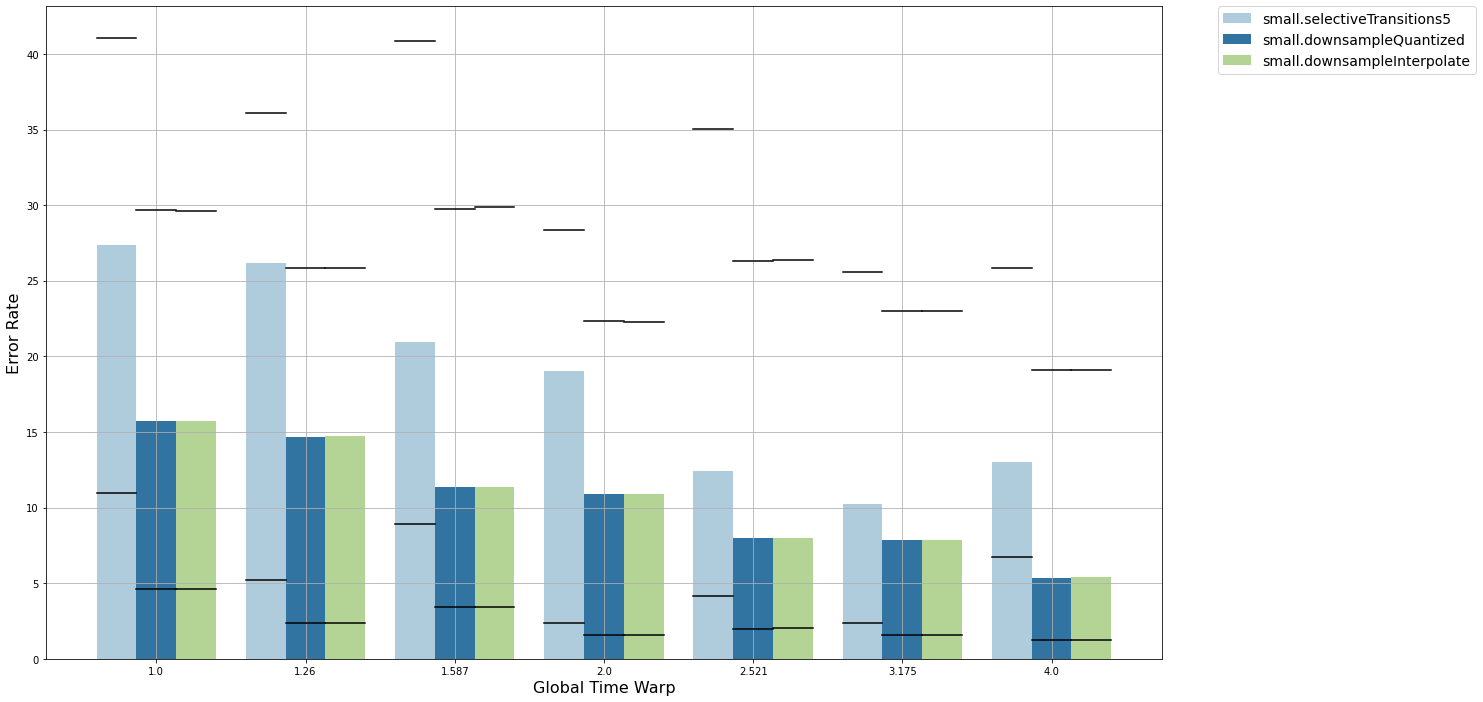

In [98]:
toPlot_sample = get_folder_names('train_small', ['selectiveTransitions5', 'downsampleQuantized', 'downsampleInterpolate'])
maxTol = 1000 # in msec
errRates_sample, errVals_sample = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot_sample, maxTol)
df_sample = generate_df_with_tols(errRates_sample, toPlot_sample, [200, 500, 100])
plot_with_tols(df_sample)

#### Graph for adaptive weights

Computing error rates ..................... done


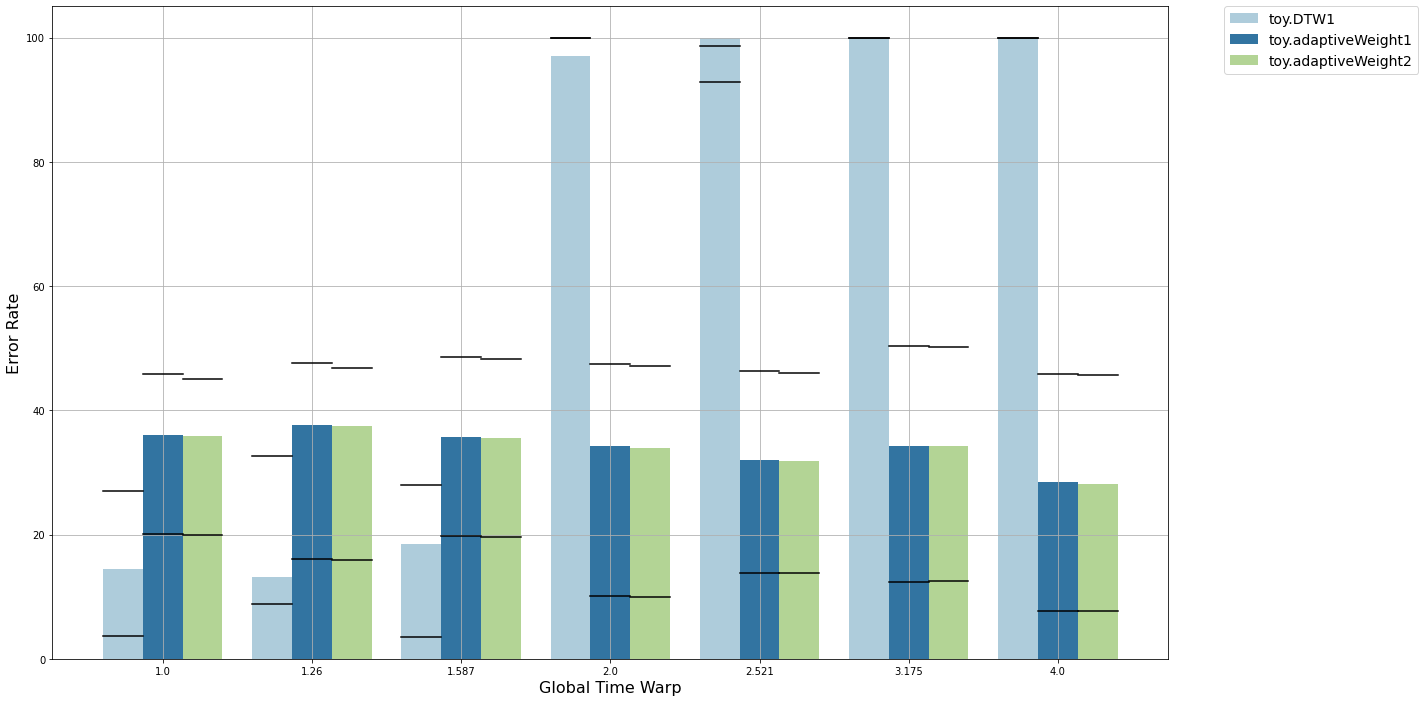

In [100]:
toPlot_weight = get_folder_names('train_toy',['DTW1', 'adaptiveWeight1', 'adaptiveWeight2'])
maxTol = 1000 # in msec
errRates_weight, errVals_weight = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot_weight, maxTol)
df_weight = generate_df_with_tols(errRates_weight, toPlot_weight, [200, 500, 100])
plot_with_tols(df_weight)

#### Graph for selective transitions

Computing error rates ................................... done


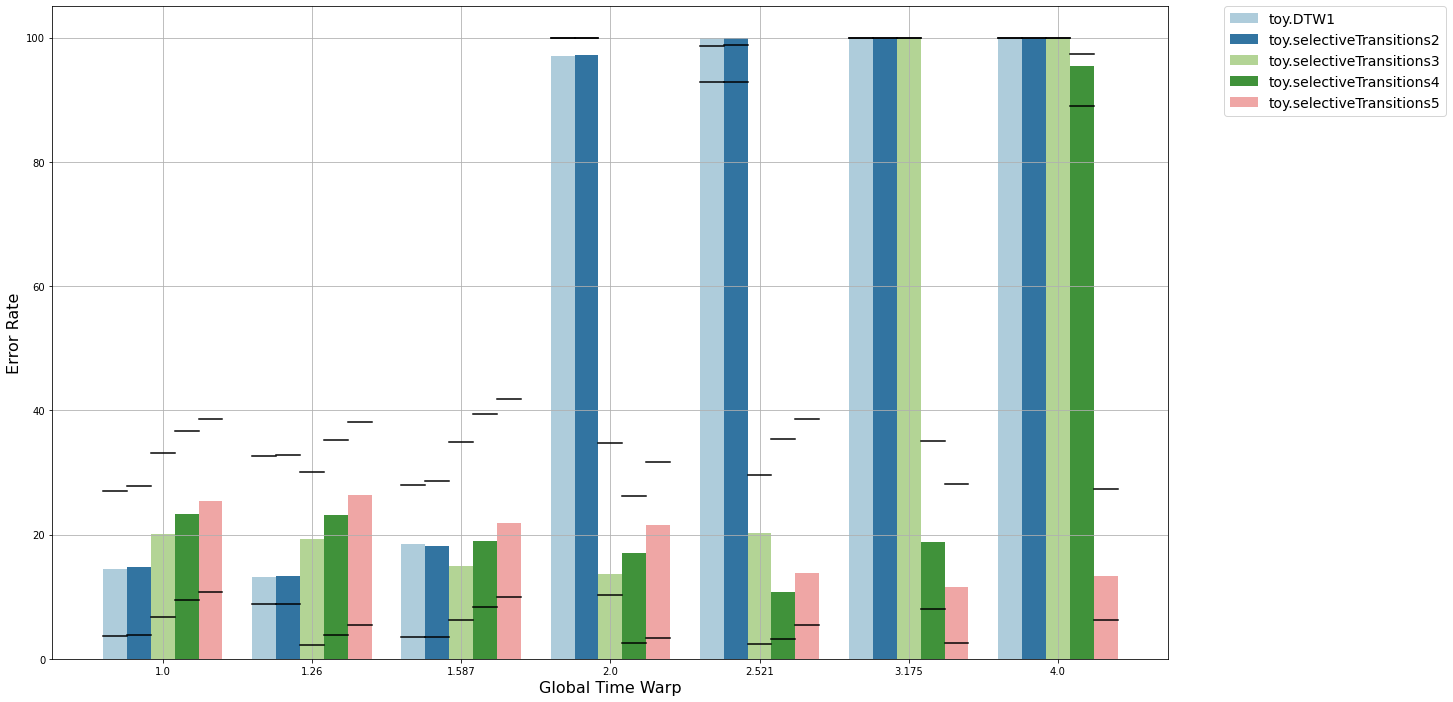

In [101]:
toPlot_selective = get_folder_names('train_toy',['DTW1', 'selectiveTransitions2', 'selectiveTransitions3', 'selectiveTransitions4', 'selectiveTransitions5'])
maxTol = 1000 # in msec
errRates_selective, errVals_selective = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot_selective, maxTol)
df_selective = generate_df_with_tols(errRates_selective, toPlot_selective, [200, 500, 100])
plot_with_tols(df_selective)

#### Graph for Sub_DTW1-7

Computing error rates ................................................. done


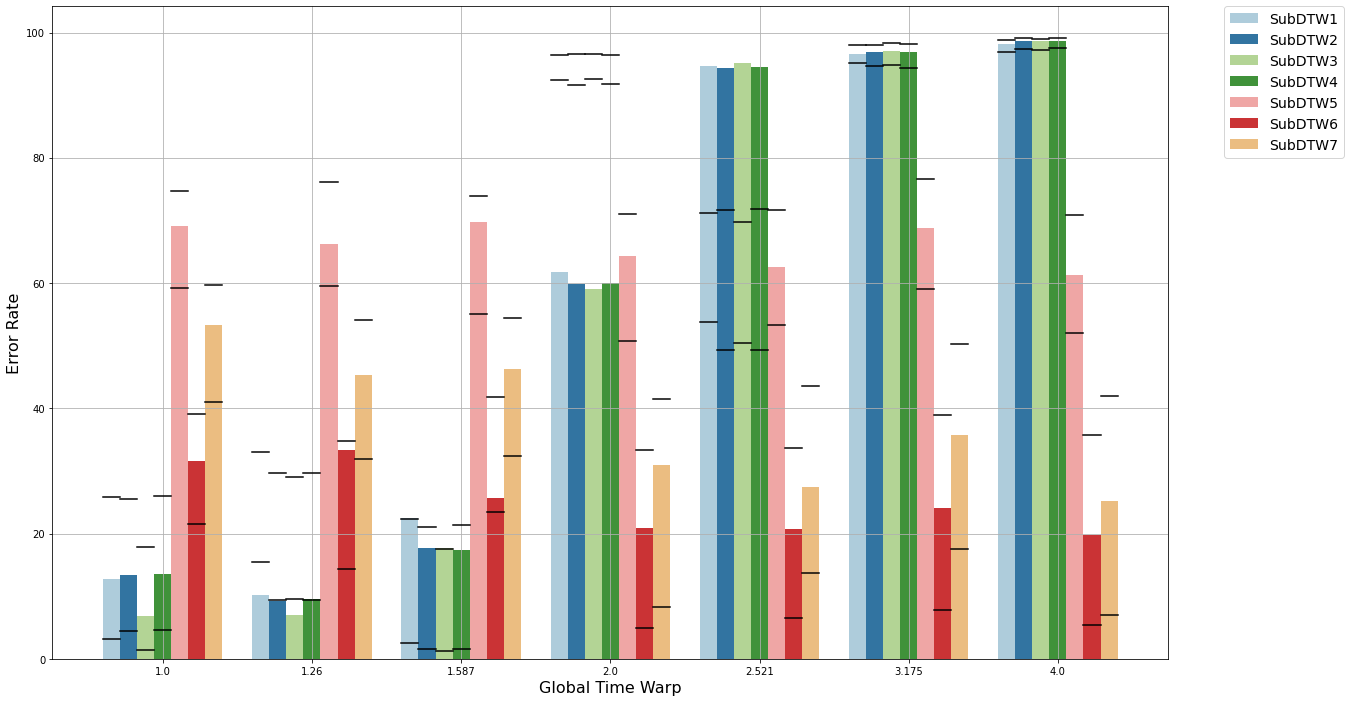

In [21]:
toPlot_sub = get_folder_names('train_toy',['SubDTW1', 'SubDTW2', 'SubDTW3','SubDTW4','SubDTW5','SubDTW6','SubDTW7'])
maxTol = 1000 # in msec
errRates_sub, errVals_sub = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot_sub, maxTol)
df_sub = generate_df_with_tols(errRates_sub, toPlot_sub, [200, 500, 100])
plot_with_tols(df_sub)

#### Graph for Sub_DTW adds

Computing error rates ................................................. done


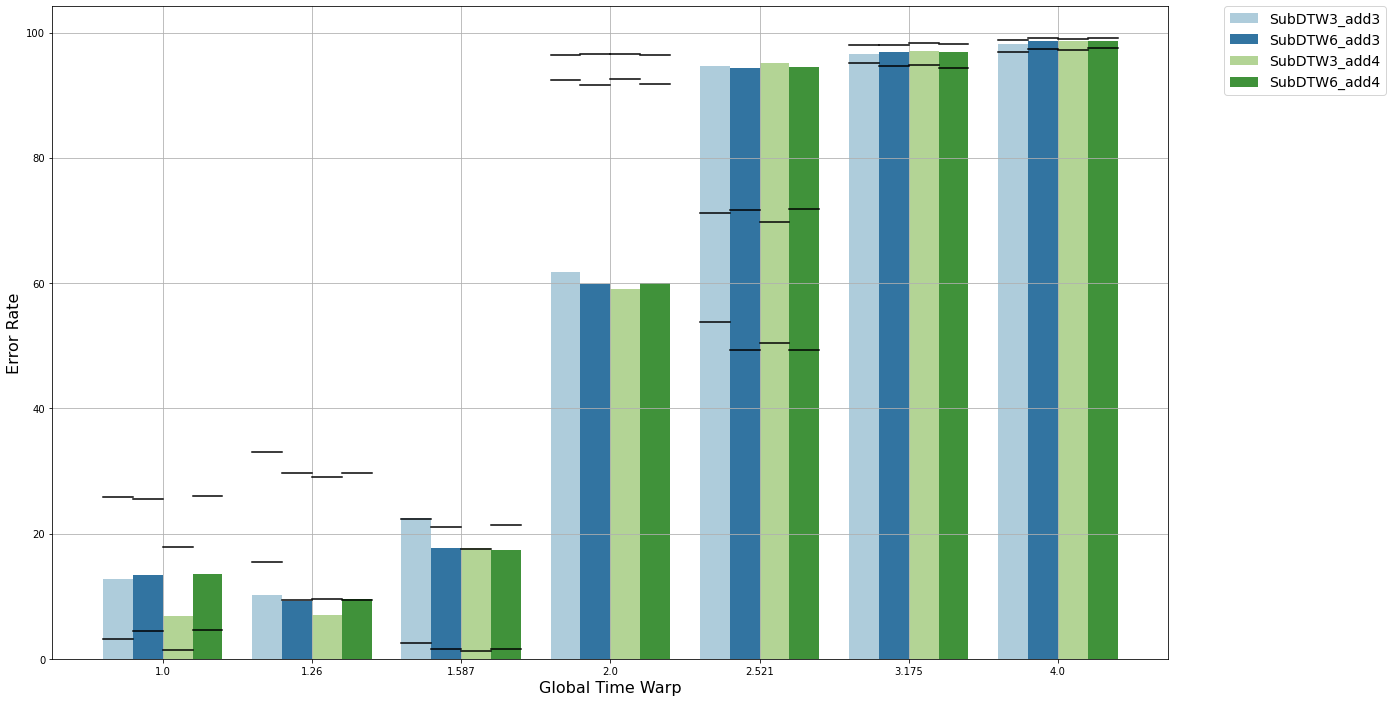

In [22]:
toPlot_sub_add = get_folder_names('train_toy',['SubDTW3_add3', 'SubDTW6_add3', 'SubDTW3_add4', 'SubDTW6_add4'])
maxTol = 1000 # in msec
errRates_sub_add, errVals_sub_add = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot_sub, maxTol)
df_sub_add = generate_df_with_tols(errRates_sub_add, toPlot_sub_add, [200, 500, 100])
plot_with_tols(df_sub_add)

#### Graph for Sub_DTW selectives

Computing error rates ............................ done


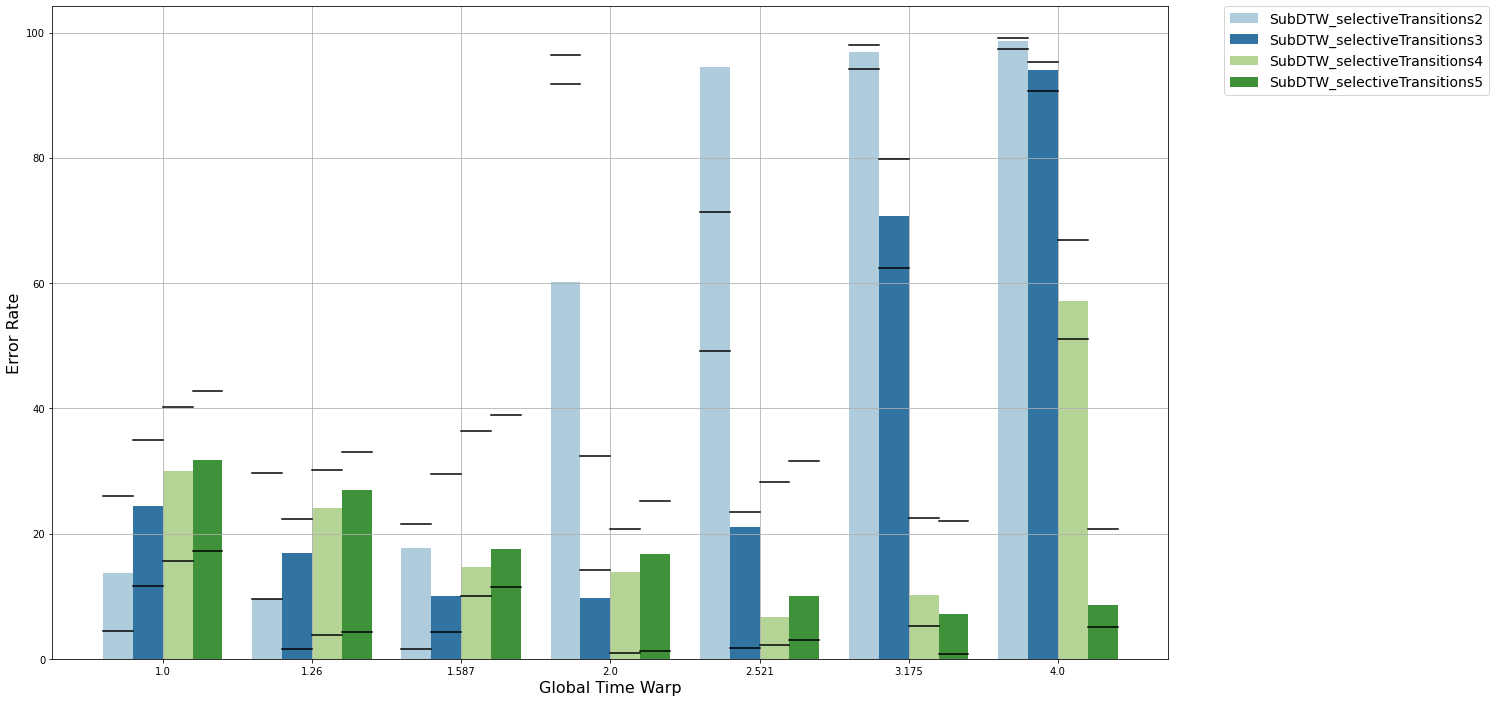

In [30]:
toPlot_sub_selective = get_folder_names('train_toy',['SubDTW_selectiveTransitions2', 'SubDTW_selectiveTransitions3', 'SubDTW_selectiveTransitions4', 'SubDTW_selectiveTransitions5'])
maxTol = 1000 # in msec
errRates_sub_selective, errVals_sub_selective = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot_sub_selective, maxTol)
df_sub_selective = generate_df_with_tols(errRates_sub_selective, toPlot_sub_selective, [200, 500, 100])
plot_with_tols(df_sub_selective)